In [2]:
from pandas.core.frame import DataFrame
import yfinance as yf
import pandas as pd
import numpy as np
import talib as ta
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

ticker = 'IRCTC'

In [4]:
start = (datetime.now() - timedelta(days=15000)).date()
end = (datetime.now() - timedelta(days=1)).date()
data = pd.read_csv('data/TATAPOWER.csv')
span = 50
model = LinearRegression()
regressor = RandomForestRegressor(n_estimators=100, random_state=0)

In [33]:
"""
	Parameters
	----------
	df -> Dataframe of stock's historical data
	indicator -> mathematical formula to make an indicator on
		Supported indicators:
			rsi -> Relative Strength Indicator
			macd -> Moving Average Convergence Divergence
			ema -> Exponential Moving Average
			volume -> It's not actually an indicator but we are using it to analyse
			price volume data by correlating price movements with volume.
	entry_type -> The view of underlying stock.
		long -> We take long entry for bullishness
		short -> We take short entry for bearishness
	"""
def get_rsi(rsiValue):
	if rsiValue in range(60,70):
		print("Here")
		return 5
	elif rsiValue in range(70,80):
		return 4
	elif rsiValue >= 80:
		return 3
	elif rsiValue in range(50,60):
		return 2
	else:
		return 0
def get_score(df: DataFrame, indicator: str, entry_type='long'):
	indicator = indicator.upper()

	if indicator == 'RSI' and entry_type == 'long':
		"""
		General Strategy with RSI:
			If RSI Value is >= 70:
				It is considered that the stock is overpriced as
				the stock is overbought in the last few trading sessions.
				
				Increasing RSI is generally considered a negative sign,
				and the stock is expected to be bearish.
			If RSI Value is <= 30:
				It is considered that the stock is underpriced as
				the stock is oversold in the last few trading sessions.

				Decreasing RSI is generally considered as a positive sign,
				and the stock is expected to be bullish in upcoming trading sessions.

		Our strategy with RSI:
			If RSI Value in range of 60-70
				We consider this the best range of RSI as if the stock has
				RSI value of >=60 and <= 70. It is not overbought but it actually
				deserves to be a performing stock.

				We expect the stock to perform more in upcoming trading sessions.

			If RSI Value in range of 70-80
				We consider this the next best range of RSI. If the stock is in 
				ragne of this we can expect bullishness but now the upmove is
				considered to be weak as the move may have came to an end as 
				RSI is already this much high.
			
			If RSI Value in range of >= 80
				We consider this as a weakening score and a potential threat, 
				as the stock might be actually overperforming. 

				This is just like a typical overbought zone.
			
			If RSI Value in range 50-60
				We consider this as a moderate range, and the stock might
				start performing from here. So we return the score with value of 2.

			If any given condition is not matched we simply return the score value of 0.
		"""
		rsiValue = df.rsi.head(1).values[0]
		if rsiValue in range(60,70):
			yield 5
		elif rsiValue in range(70,80):
			return 4
		elif rsiValue >= 80:
			return 3
		elif rsiValue in range(50,60):
			return 2
		else:
			return 0
	"""
		General Strategy with MACD:
			In MACD there are two components which are calculated.
			MACD Signal and MACD.
			If value of MACD is greaten than MACD Signal, 
				it is considered a bullish crossover and the stock might
				start performing from here.
			If value of MACD is less than MACD Signal,
				it is considered a bearish crossover and the stock might
				start falling from here.

		Our Strategy with MACD:
			We go along with the general strategy but with some modifications.
			Instead of simply checking the condition of MACD > Macd Signal, 
			we check when the crossover happened.

			The nearer the crossover with today's date the more strength the
			buy signal has.
	"""
	if indicator == 'MACD' and entry_type == 'long':
		macd = df.macd_crossover
		try:
			date = macd.iloc[list(np.where(df["macd_crossover"] == 1)[0])].index.values[0]
			date = pd.to_datetime(date)
			dates = df.index.values
			for i in range(0,len(dates)):
				if pd.to_datetime(dates[i]).date() == date:
					return 5 - i
			return 0
		except IndexError:
			return 0
	if indicator == 'MACD_BUY' and entry_type == 'long':
		macd = df.macd_buy
		try:
			date = macd.iloc[list(np.where(df["macd_buy"] == 1)[0])].index.values[0]
			date = pd.to_datetime(date)
			dates = df.index.values
			for i in range(0,len(dates)):
				if pd.to_datetime(dates[i]).date() == date:
					return 5 - i
			return 0
		except IndexError:
			return 0
	if indicator == 'EMA_BUY' and entry_type == 'long':
		try:
			date = df.ema_buy.iloc[list(np.where(df["ema_buy"] == 1)[0])].index.values[0]
			date = pd.to_datetime(date)
			dates = df.index.values
			for i in range(0,len(dates)):
				if pd.to_datetime(dates[i]).date() == date:
					return 5 - i
			return 0
		except IndexError:
			return 0
	if indicator == 'EMA' and entry_type == 'long':
		try:
			date = df.ema_crossover.iloc[list(np.where(df["ema_crossover"] == 1)[0])].index.values[0]
			date = pd.to_datetime(date)
			dates = df.index.values
			for i in range(0,len(dates)):
				if pd.to_datetime(dates[i]).date() == date:
					return 5 - i
			return 0
		except IndexError:
			return 0
	if indicator == 'VOLUME' and entry_type == 'long':
		try:
			date = df.volume_buy.iloc[list(np.where(df["volume_buy"] == 1)[0])].index.values[0]
			date = pd.to_datetime(date)
			dates = df.index.values
			for i in range(0,len(dates)):
				if pd.to_datetime(dates[i]).date() == date:
					return 5 - i
			return 0
		except IndexError:
			return 0
	return None

In [34]:
data = data.tail(span+5)
data['5EMA'] = pd.Series.ewm(data['Close'], span=5).mean()
data['26EMA'] = pd.Series.ewm(data['Close'], span=26).mean()
data['rsi'] = ta.RSI(data['Close'].values, timeperiod=14)

data['macd'], data['macdSignal'], data['macdHist'] = ta.MACD(data.Close.values, fastperiod=12, slowperiod=26, signalperiod=9)

data['macd_crossover'] = np.where(((data.macd > data.macdSignal) & (data.macd.shift(1) < data.macdSignal.shift(1))), 1, 0)
data['macd_crossunder'] = np.where(((data.macd < data.macdSignal) & (data.macd.shift(1) > data.macdSignal.shift(1))), 1, 0)
data['ema_crossover'] = np.where(((data['5EMA'].shift(1) <= data['26EMA'].shift(1)) & (data['5EMA'] > data['26EMA'] )), 1, 0)
data['ema_crossunder'] = np.where(((data['5EMA'].shift(1) >= data['26EMA'].shift(1)) & (data['5EMA'] < data['26EMA'] )), 1, 0)
data['macd_buy'] = np.where((data.macd > data.macdSignal), 1, 0)
data['macd_sell'] = np.where((data.macd < data.macdSignal), 1, 0)
data['ema_buy'] = np.where((data['5EMA'] > data['26EMA']), 1, 0)
data['ema_sell'] = np.where((data['5EMA'] < data['26EMA']), 1, 0)
data['rsi_buy'] = np.where(data.rsi >= 60, 1, 0)
data['rsi_sell'] = np.where(data.rsi <= 40, 1, 0)

data['volume_buy'] = np.where((data.Volume > data.Volume.ewm(span=5).mean()) & (data.Close > data.Close.shift(1)), 1, 0)
data['volume_sell'] = np.where((data.Volume > data.Volume.ewm(span=5).mean()) & (data.Close < data.Close.shift(1)), 1, 0)

In [130]:
data = data.iloc[-span:,:]
data['totalScore'] = totalScoreL[-span:]
data['totalScoreEma'] = data.totalScore.ewm(span=5).mean()
data['dates'] = data.index.values
data['dates'] = data['dates'].apply(lambda x: str(x.date()).split('-')[2])
totalScoreX = data.iloc[:,-2:-1]
datesY = data["dates"]
datesY = datesY.astype(int)


C:\Users\HP\AppData\Local\Programs\Python\Python38-32\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


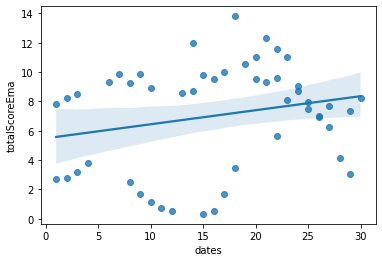

In [131]:
import seaborn as sns
sns.regplot(datesY, totalScoreX)
plt.show()

C:\Users\HP\AppData\Local\Programs\Python\Python38-32\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


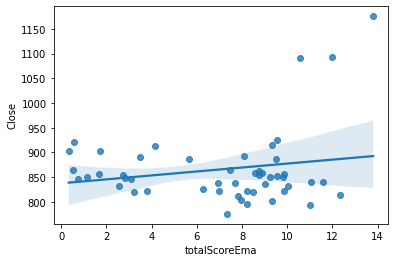

In [132]:
import seaborn as sns
sns.regplot(data['totalScoreEma'], data['Close'])
plt.show()

In [133]:
model.fit(np.array(datesY).reshape(-1, 1), totalScoreX)
yhat = model.predict([[29]]) #predict score for next day
yhat

array([[8.25909238]])

In [134]:
data.iloc[:,-2:]
regressor.fit(np.asarray(data['totalScoreEma']).reshape(-1, 1),data['Close'])
price = float(regressor.predict(yhat))
price

808.8122155761719

In [135]:
max_std = data.Close.values[-1] + data.Close.std() / 2
min_std = data.Close.values[-1] - data.Close.std() / 2
max_std, min_std

(875.9483348396453, 802.0516651603547)

In [137]:
import math
if not price in range(int(math.floor(min_std)), int(math.ceil(max_std))):
	if price > max_std:
		price = max_std - data.Close.std() / 2
	else:
		price = min_std + data.Close.std() / 2
price

839.0